In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/borsa_study

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/borsa_study


In [2]:
data_list = ["TRY=X","EURTRY=X","XU100.IS","XU030.IS","XUSIN.IS","LBSU22.CME","SUMAS.IS","ORMA.IS","YONGA.IS","LBS=F"]

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import norm, skew
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from warnings import simplefilter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import math
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.deterministic import DeterministicProcess
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,LSTM,Dropout
import os
simplefilter("ignore")

Yukaridaki listede bulunan tum sirket ve endekslerin Pearson Correlation matrix de iliskilerini yorumlayabilmek icin kapanis fiyatlari ve hacim verisi ile birlikte bir DataFrame olusturma

In [4]:
df_corr = pd.DataFrame()
dfsod = pd.read_csv('stock_history/SUMAS.IS/SUMAS.ISd.csv')
df_corr['Datetime'] = pd.to_datetime(dfsod['Date'])
df_corr = df_corr.set_index('Datetime')

st_hist_path = '/content/gdrive/MyDrive/borsa_study/stock_history'


for dirname, _, filenames in os.walk(st_hist_path):
    for filename in filenames:
      if filename.endswith('d.csv'):
        df_temp = pd.read_csv('stock_history/' + filename.strip('d.csv') + '/' + filename)
        df_temp['Datetime'] = pd.to_datetime(df_temp['Date'])
        df_temp = df_temp.set_index('Datetime')
        df_temp = df_temp.drop(['Date'], axis=1)
        trail_name = filename.strip('.ISd.csv')
        if trail_name == 'UMA':
          trail_name = 'SUMAS'
        col_close = trail_name + '_close'
        col_vol = trail_name + '_vol'
        df_corr[col_close] = df_temp['Close']
        df_corr[col_vol] = df_temp['Volume']

In [5]:
df_corr.drop(columns=['TRY=X_vol','EURTRY=X_vol','LBSU22.CME_vol'], axis=1)
df_corr.describe()

,SUMAS_close,SUMAS_vol,LBSU22.CME_close,LBSU22.CME_vol,ORMA_close,ORMA_vol,YONGA_close,YONGA_vol,XUSIN_close,XUSIN_vol,XU100_close,XU100_vol,XU030_close,XU030_vol,TRY=X_close,TRY=X_vol,EURTRY=X_close,EURTRY=X_vol,LBS=F_close,LBS=F_vol
count,502.000000,502.000000,276.000000,276.000000,502.000000,502.000000,502.000000,502.000000,491.000000,4.910000e+02,500.000000,5.000000e+02,491.000000,4.910000e+02,502.000000,502.0,502.000000,502.0,483.000000,483.000000
mean,69.325259,7481.276892,745.613770,61.376812,26.468586,25913.069721,26.324442,29801.790837,3061.935478,1.157953e+06,1773.732019,3.373325e+09,1937.619284,2.196571e+06,11.009596,0.0,12.394413,0.0,844.277432,210.871636
std,17.206666,9384.233642,158.784383,111.257683,7.793346,34336.800135,7.726888,47200.785431,904.492813,4.537249e+05,522.333467,1.491095e+09,585.135549,1.062032e+06,3.705775,0.0,3.437747,0.0,285.360074,124.898582
min,22.580000,81.000000,479.200012,0.000000,8.900000,805.000000,18.000000,350.000000,1568.900024,0.000000e+00,1087.000000,0.000000e+00,1213.199951,0.000000e+00,6.956900,0.0,8.387260,0.0,454.200012,13.000000
25%,61.237501,2675.500000,615.224991,0.000000,21.025000,8344.750000,21.630001,9509.250000,2473.849976,8.095500e+05,1399.624969,2.243545e+09,1496.700012,1.445600e+06,7.940525,0.0,9.511283,0.0,598.750000,125.000000
50%,72.025002,4454.000000,724.350006,5.000000,28.440001,14159.500000,24.370000,15222.500000,2667.500000,1.098700e+06,1533.349976,3.044536e+09,1631.000000,1.954200e+06,8.682500,0.0,10.345675,0.0,800.099976,198.000000
75%,81.000000,7974.750000,860.099976,60.500000,32.060001,28387.000000,29.000000,29100.750000,3754.700073,1.473600e+06,2084.825012,4.394259e+09,2335.400024,2.772300e+06,14.541310,0.0,15.667273,0.0,1020.000000,272.500000
max,107.000000,78005.000000,1074.300049,647.000000,39.500000,402858.000000,81.400002,597643.000000,5219.220215,3.075900e+06,3437.409912,9.457914e+09,3766.070068,7.806900e+06,18.230230,0.0,18.655109,0.0,1686.000000,999.000000


In [6]:
dfsh = pd.read_csv('outputs/fresh_rolling_train/df_SUMAS.IS.csv')
dfsd = pd.read_csv('outputs/fresh_rolling_train/df_SUMAS.ISd.csv')
dfsoh = pd.read_csv('stock_history/SUMAS.IS/SUMAS.IS.csv')
dfsod = pd.read_csv('stock_history/SUMAS.IS/SUMAS.ISd.csv')
dfooh = pd.read_csv('stock_history/ORMA.IS/ORMA.IS.csv')
dfood = pd.read_csv('stock_history/ORMA.IS/ORMA.ISd.csv')
dfyoh = pd.read_csv('stock_history/YONGA.IS/YONGA.IS.csv')
dfyod = pd.read_csv('stock_history/YONGA.IS/YONGA.ISd.csv')
dflbsod = pd.read_csv('stock_history/LBSU22.CME/LBSU22.CMEd.csv')

In [7]:
dfsod['Datetime'] = pd.to_datetime(dfsod['Date'])
#dfsod = dfsod.set_index('Datetime')
dfsod = dfsod.drop(['Date'], axis=1)
dfsod.describe().style.background_gradient(cmap='Blues')
dfsod.head()

,Open,High,Low,Close,Volume,Datetime
0,22.580000,22.580000,22.580000,22.580000,6092,2020-09-08
1,24.820000,24.820000,24.820000,24.820000,10393,2020-09-09
2,27.299999,27.299999,25.000000,27.000000,78005,2020-09-10
3,25.799999,25.799999,25.000000,25.000000,33793,2020-09-11
4,27.459999,27.459999,27.459999,27.459999,16566,2020-09-14


In [8]:
dfsod.head(5).style.background_gradient(cmap='Oranges')

,Open,High,Low,Close,Volume,Datetime
0,22.580000,22.580000,22.580000,22.580000,6092,2020-09-08 00:00:00
1,24.820000,24.820000,24.820000,24.820000,10393,2020-09-09 00:00:00
2,27.299999,27.299999,25.000000,27.000000,78005,2020-09-10 00:00:00
3,25.799999,25.799999,25.000000,25.000000,33793,2020-09-11 00:00:00
4,27.459999,27.459999,27.459999,27.459999,16566,2020-09-14 00:00:00


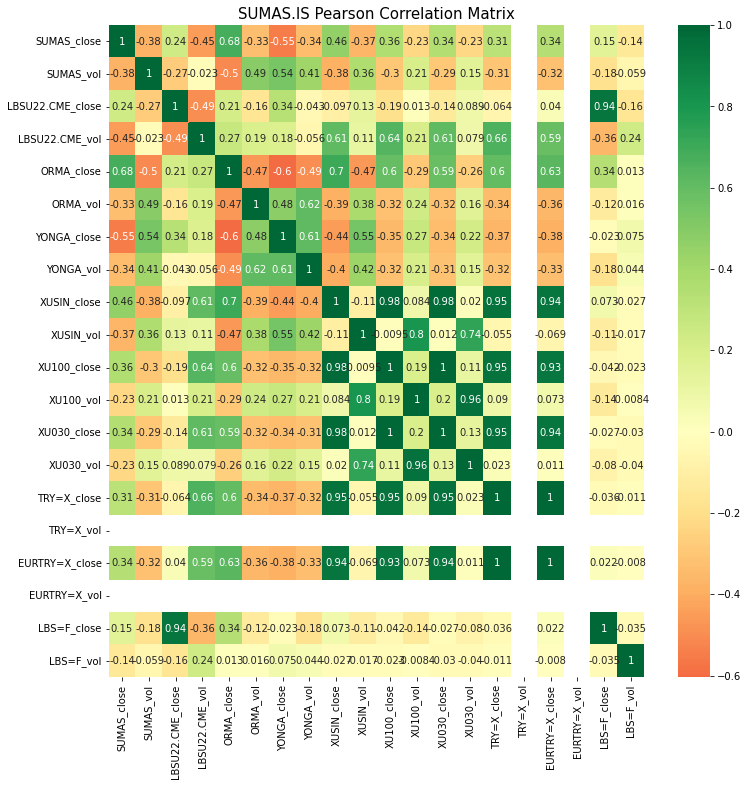

In [9]:
plt.figure(figsize=(12,12))
plt.title('SUMAS.IS Pearson Correlation Matrix', fontsize=15)
# corr = dfsoh.iloc[:,1:].corr()
corr = df_corr.corr()
p = sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0) 

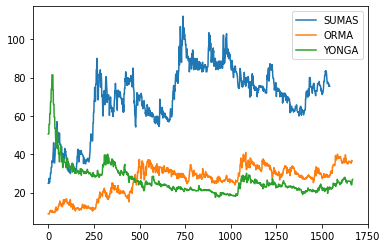

In [10]:
plt.plot(dfsoh['Close'])
plt.plot(dfooh['Close'])
plt.plot(dfyoh['Close'])
plt.legend(['SUMAS', 'ORMA', 'YONGA'])

In [11]:
sns.set()
plt.figure(figsize=(5,5))
cols = list(df_corr.columns)
sns.pairplot(df_corr[cols], size=2.5)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
plt.style.use('fivethirtyeight')
df2 = dfsod.copy().set_index('Datetime')

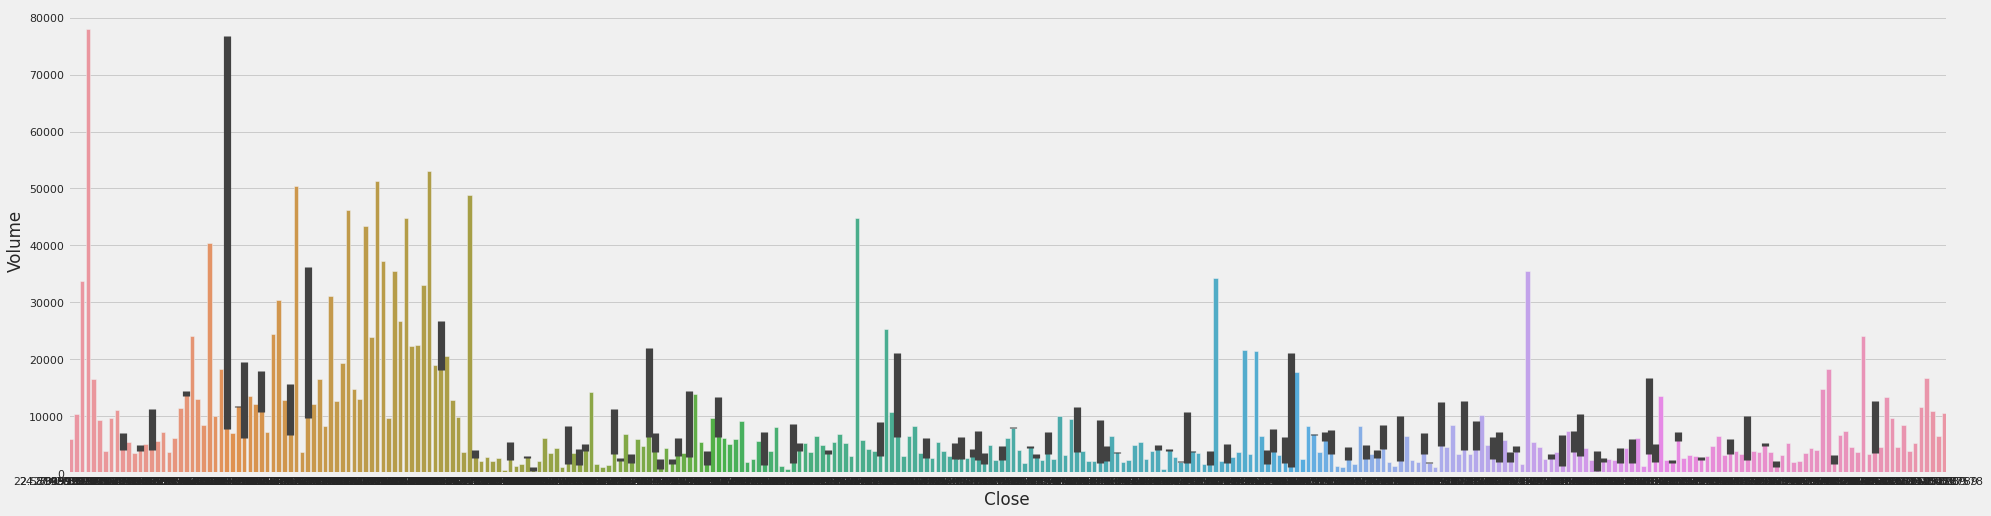

In [13]:
plt.figure(figsize=(30,8))
sns.barplot(data=df2, x='Close', y='Volume')
plt.show()

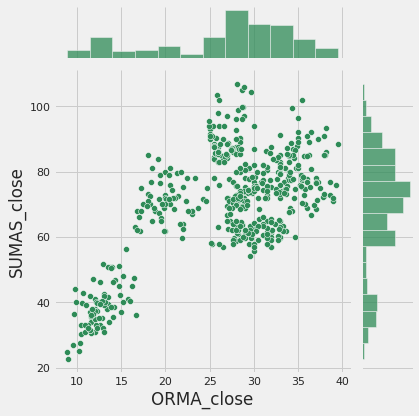

In [14]:
sns.jointplot(x='ORMA_close', y='SUMAS_close', data=df_corr, kind='scatter', color='seagreen')
plt.show()

In [15]:
#df_corr['Date'] = dfsod['Date']
#df_corr['Datetime'] = pd.to_datetime(df_corr['Date'])
#df_corr = df_corr.set_index('Datetime')

In [16]:
#df_corr = df_corr.drop(['Date'], axis=1)

In [17]:
df_corr.tail()

,SUMAS_close,SUMAS_vol,LBSU22.CME_close,LBSU22.CME_vol,ORMA_close,ORMA_vol,YONGA_close,YONGA_vol,XUSIN_close,XUSIN_vol,XU100_close,XU100_vol,XU030_close,XU030_vol,TRY=X_close,TRY=X_vol,EURTRY=X_close,EURTRY=X_vol,LBS=F_close,LBS=F_vol
Datetime,,,,,,,,,,,,,,,,,,,,
2022-09-02,80.949997,3464,493.799988,85.0,36.520000,15807,25.900000,13749,5036.600098,1259100.0,3222.699951,6.328387e+09,3494.199951,4531200.0,18.207100,0,18.110319,0,493.799988,85.0
2022-09-05,76.800003,6766,NaN,NaN,36.020000,14626,25.799999,19229,5172.600098,1780600.0,3358.399902,7.199086e+09,3669.199951,5633600.0,18.211029,0,18.047300,0,NaN,NaN
2022-09-06,76.800003,6937,490.000000,83.0,36.000000,13060,24.820000,18036,5194.100098,2277700.0,3391.399902,9.055035e+09,3703.000000,7261100.0,18.214149,0,18.122681,0,490.000000,83.0
2022-09-07,75.500000,4510,505.500000,83.0,35.299999,14746,24.459999,12818,5186.500000,1731400.0,3402.800049,7.007009e+09,3728.300049,5406000.0,18.226210,0,18.041300,0,505.500000,85.0
2022-09-08,75.449997,6470,514.900024,94.0,36.380001,15143,26.900000,23150,5219.220215,0.0,3437.409912,0.000000e+00,3766.070068,0.0,18.230230,0,18.231970,0,513.400024,101.0


Exploratory Data Analysis(EDA)

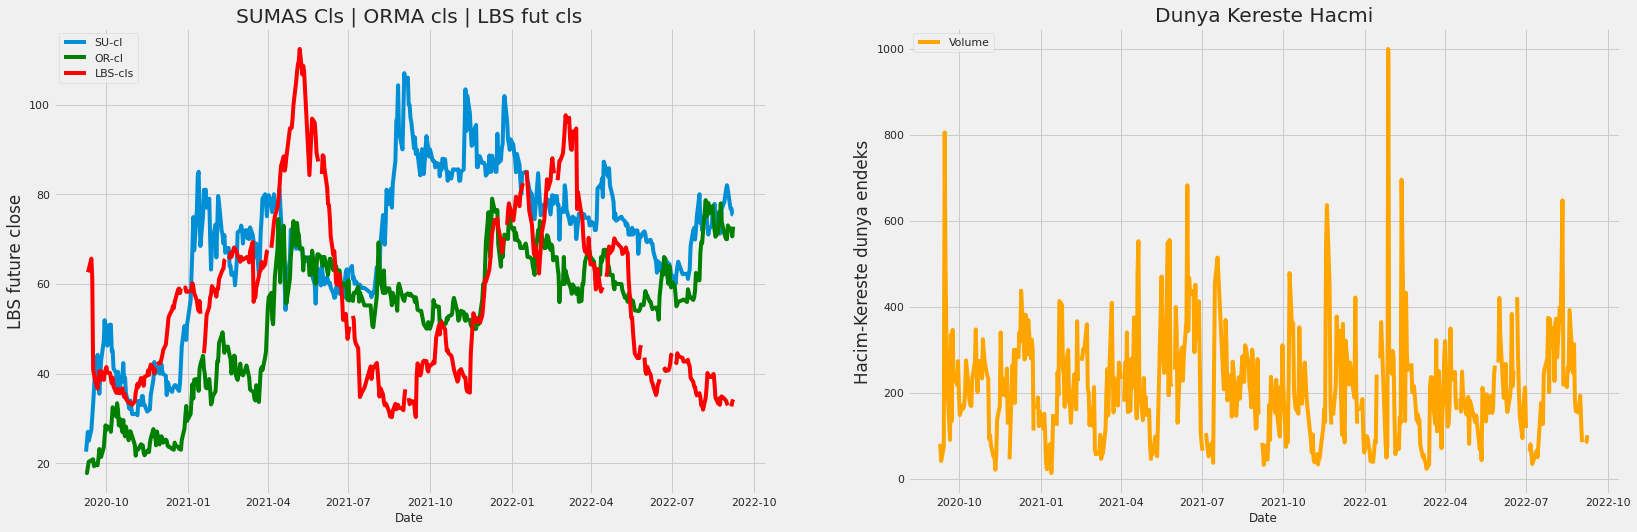

In [18]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(25,8))
ax1.plot(df_corr['SUMAS_close'])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("SUMAS Price")

ax1.plot( df_corr["ORMA_close"]*2, color="green")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("ORMA Price")

ax1.plot( df_corr["LBS=F_close"]/15, color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("LBS future close")

ax1.set_title("SUMAS Cls | ORMA cls | LBS fut cls")
ax1.legend(["SU-cl","OR-cl","LBS-cls"], loc='upper left')

ax2.plot(df_corr["LBS=F_vol"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Hacim-Kereste dunya endeks")
ax2.set_title("Dunya Kereste Hacmi")
ax2.legend(["Volume"], loc='upper left')

plt.show()

In [19]:
def create_features(df):
    df['Dateofmonth'] = df['Datetime'].dt.day
    df['Month'] = df['Datetime'].dt.month
    df['Week'] = df['Datetime'].dt.week
    df['Dayofweek'] = df['Datetime'].dt.dayofweek
    df['Month'] = df['Datetime'].dt.month
    df['Quarter'] = df['Datetime'].dt.quarter
    df["Year"] = df["Datetime"].dt.year
    df['Dayofyear'] = df['Datetime'].dt.dayofyear
    return df

In [20]:
df = create_features(dfsod)
dfsod = dfsod.set_index('Datetime')

In [21]:
dfsod.index

DatetimeIndex(['2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11',
               '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17',
               '2020-09-18', '2020-09-21',
               ...
               '2022-08-25', '2022-08-26', '2022-08-29', '2022-08-31',
               '2022-09-01', '2022-09-02', '2022-09-05', '2022-09-06',
               '2022-09-07', '2022-09-08'],
              dtype='datetime64[ns]', name='Datetime', length=502, freq=None)

In [22]:
date1 = "2022-06"
candlestick = go.Candlestick(
                            x=dfsod.loc[dfsod.index>=date1].index,
                            open=dfsod.loc[dfsod.index>=date1]['Open'],
                            high=dfsod.loc[dfsod.index>=date1]['High'],
                            low=dfsod.loc[dfsod.index>=date1]['Low'],
                            close=dfsod.loc[dfsod.index>=date1]['Close']
                            )


layout = {
    'title': f"Lets zoom into 2021 initial 2 Months Data"
}
fig = go.Figure(data=[candlestick],layout=layout)

fig.show()

In [23]:
simplefilter("ignore") 


plt.style.use("fivethirtyeight")
# plt.style.use("dark_background")
# plt.figure(figsize=(30,10))
plt.rc("figure", autolayout=True, figsize=(30,10))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.1",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

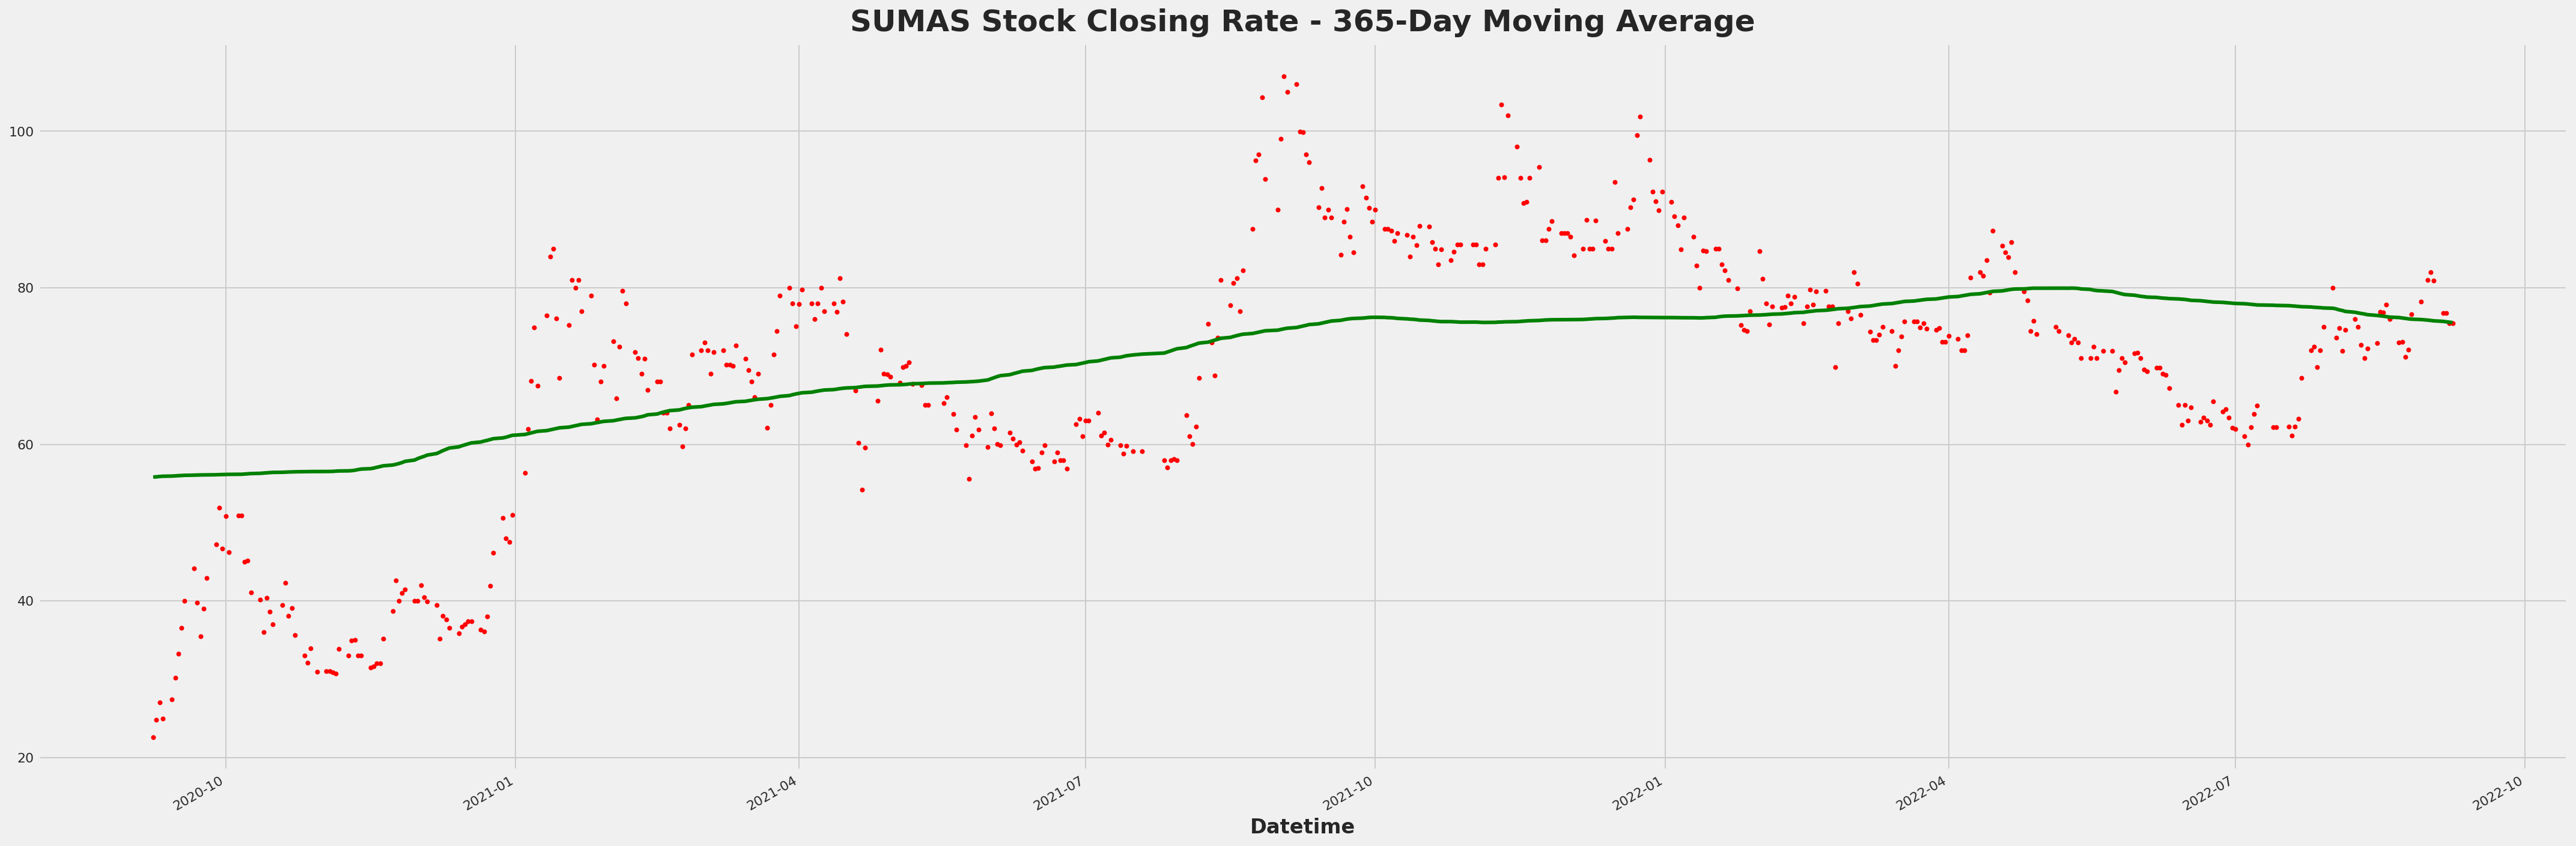

In [24]:
moving_average = dfsod["Close"].rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()             

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=25,
    titlepad=10,
)
ax = dfsod["Close"].plot(style=".", color="red")
moving_average.plot(
    ax=ax, linewidth=3, title="SUMAS Stock Closing Rate - 365-Day Moving Average",color="green", legend=False,
)

In [25]:
dp = DeterministicProcess(
    index=dfsod.index,  
    constant=True,    
    order=1,             
    drop=True,        
)

X = dp.in_sample()

In [26]:
from sklearn.linear_model import LinearRegression

y = dfsod["Close"]  


model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

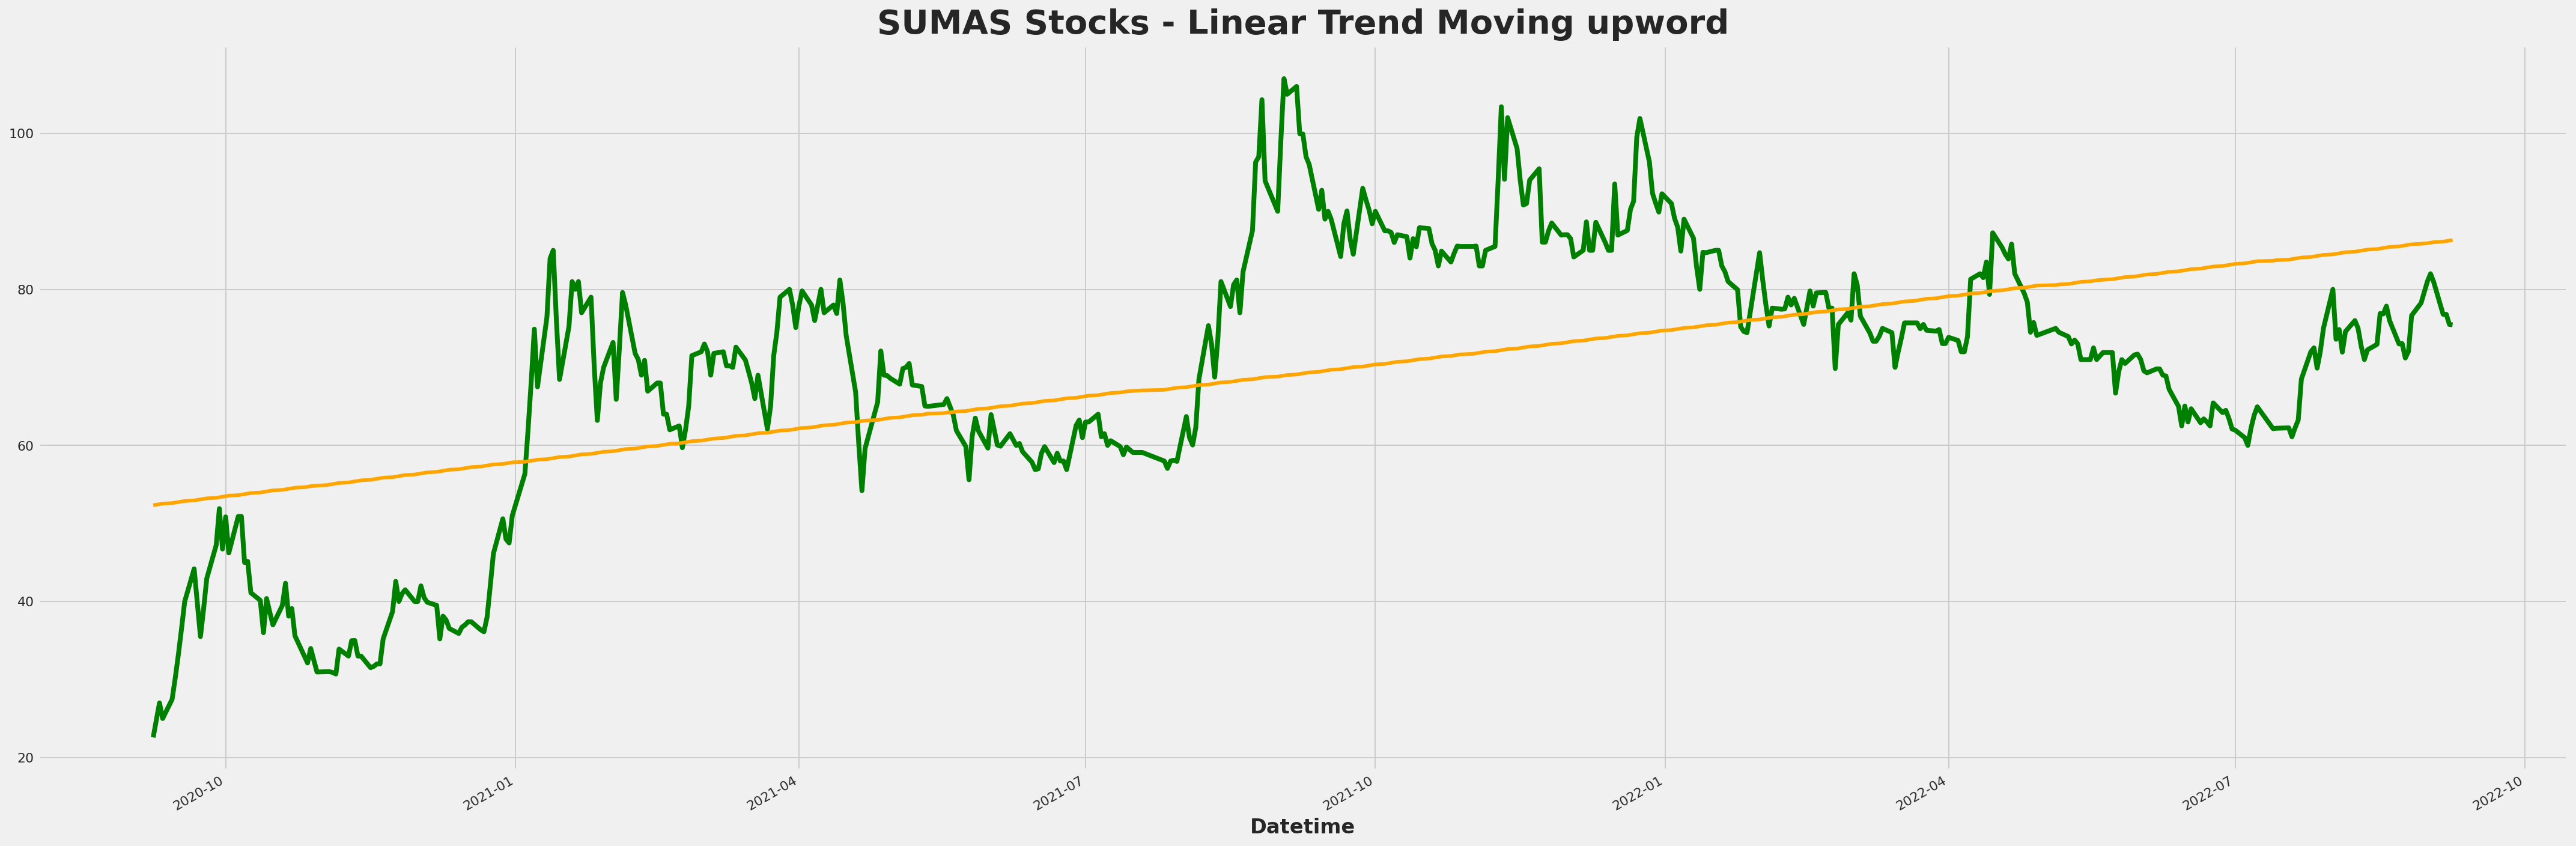

In [27]:
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=28,
    titlepad=10,
)
ax = dfsod["Close"].plot(color="green", title="SUMAS Stocks - Linear Trend Moving upword")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend",color="orange")

In [28]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")


# plt.style.use("dark_background")
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=20,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'



def seasonal_check(X, y, period, freq,title =None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    if title is None:
        title = f"Seasonal Plot ({period}/{freq})"
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(title)
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

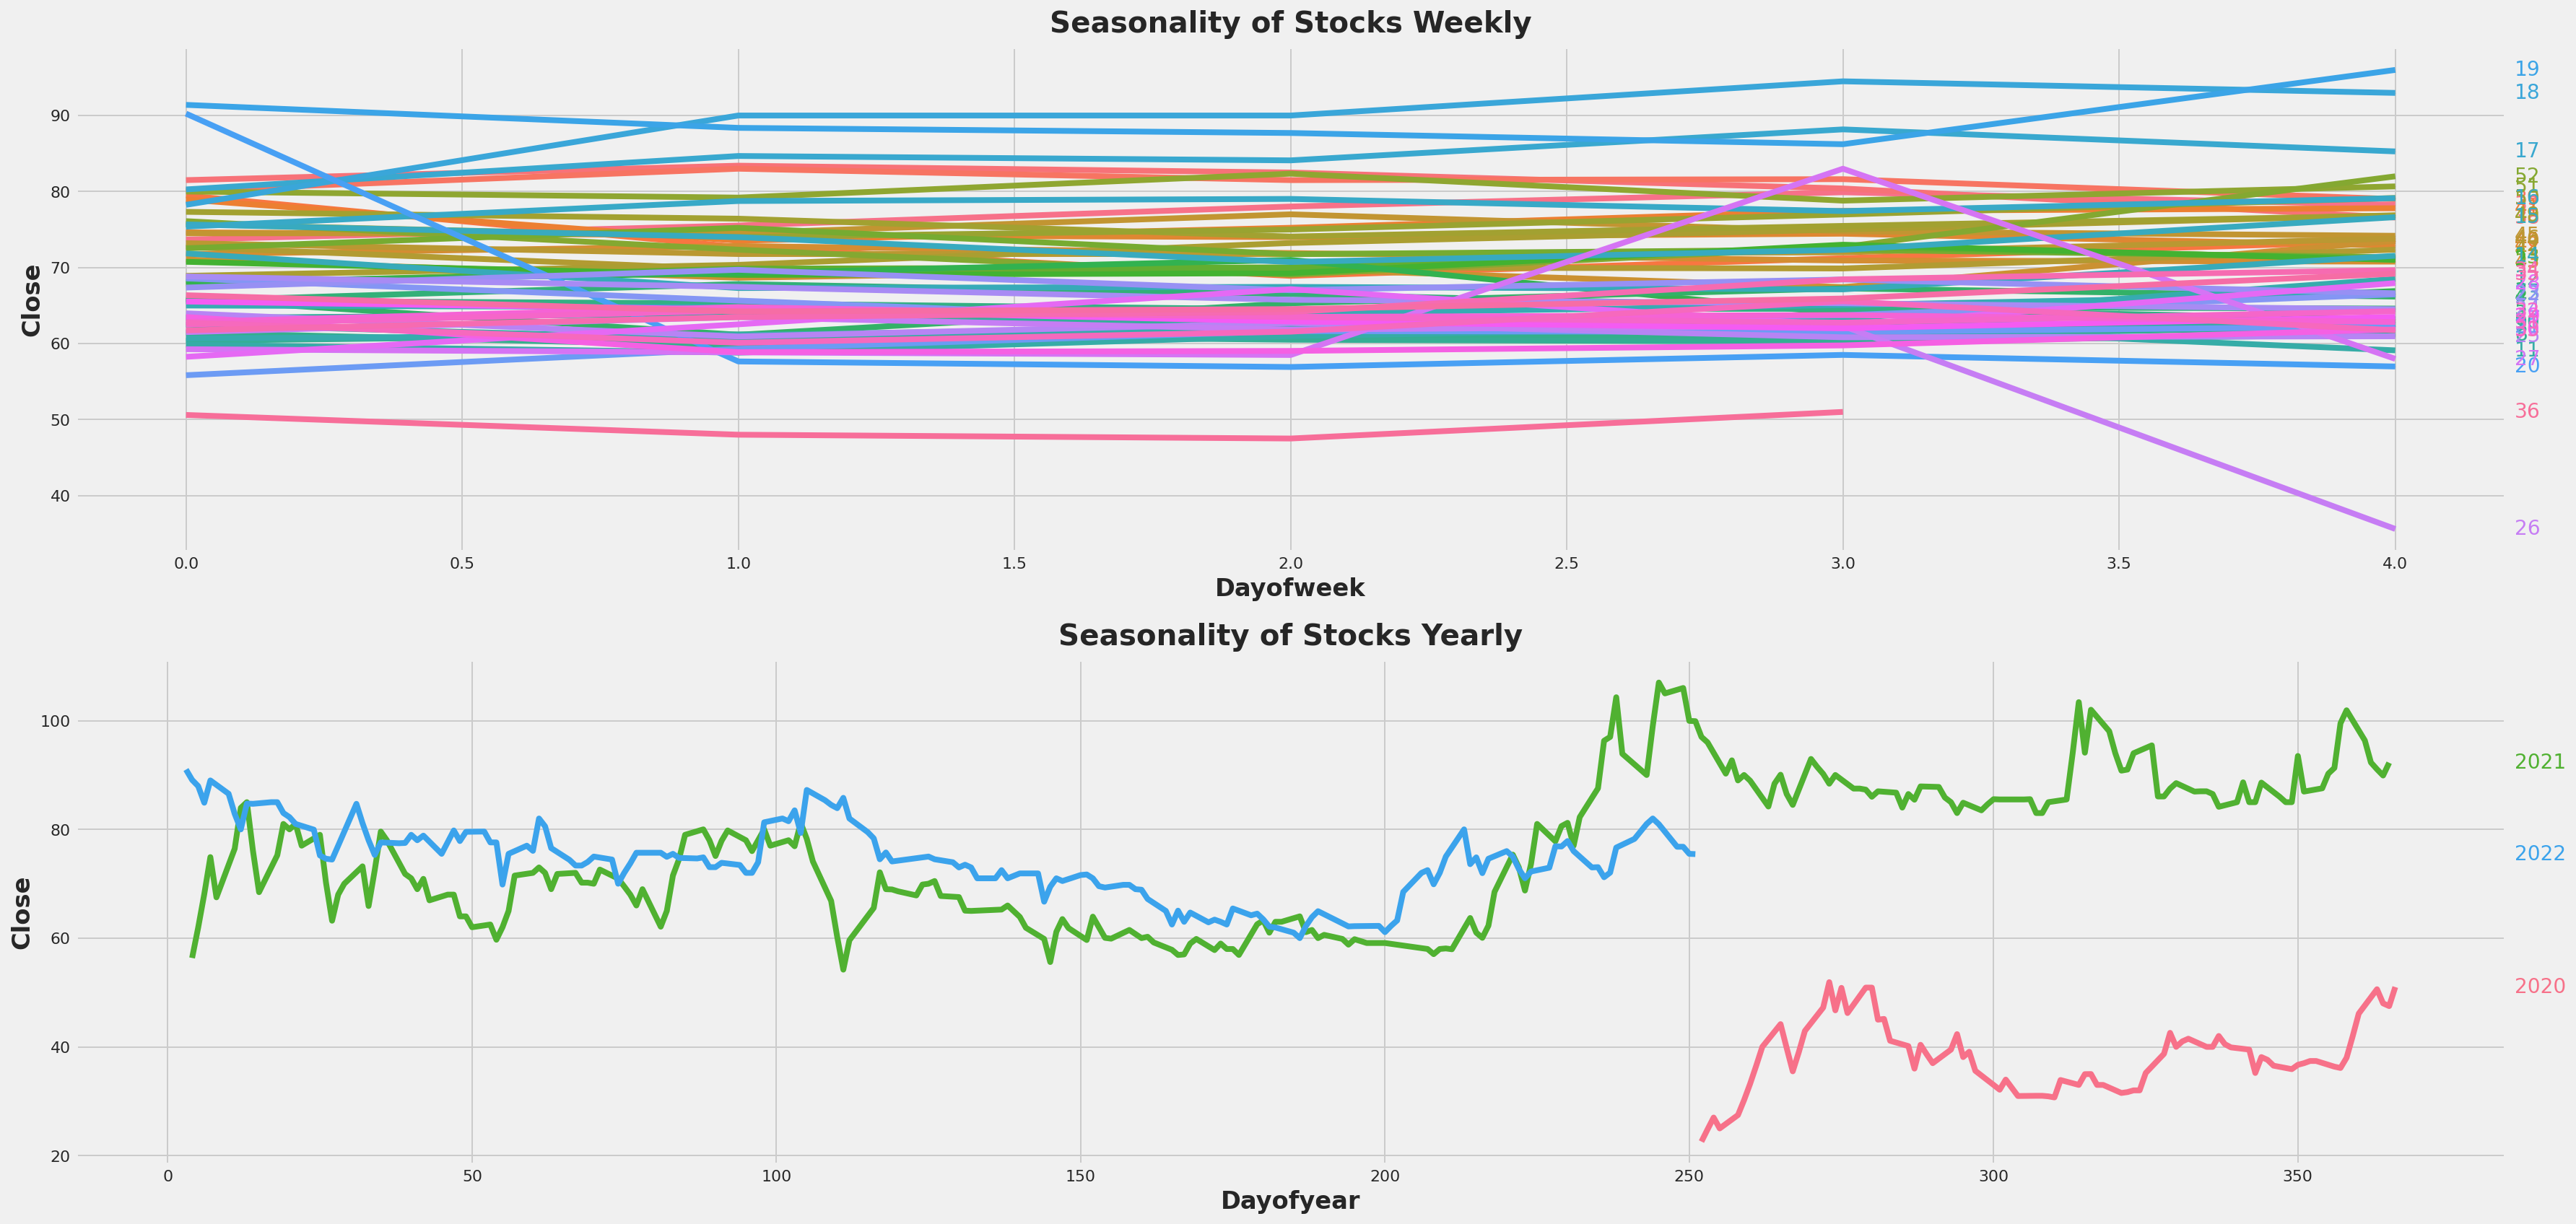

In [29]:
X =  df.copy().set_index("Datetime")
# plt.style.use("dark_background")
plt.style.use("fivethirtyeight")
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(25, 12))
seasonal_check(X, y="Close", period="Week", freq="Dayofweek",title = "Seasonality of Stocks Weekly", ax=ax0)
seasonal_check(X, y="Close", period="Year", freq="Dayofyear",title = "Seasonality of Stocks Yearly", ax=ax1)
plt.show()

ARIMA modelleme ile future SUMAs price Prediction

In [30]:
train_data, test_data = df[0:int(len(df)*0.7)].set_index("Datetime"), df[int(len(df)*0.7):].set_index("Datetime")
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error_arima = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is for Arima {}'.format(MSE_error_arima))

Testing Mean Squared Error is for Arima 5.838134547830341


In [31]:
c = int(len(df)*0.7)
test = pd.DataFrame()
test["Datetime"]= df.loc[c:,'Datetime']
test["Close"] = df.loc[c:,'Close']
test = test.set_index('Datetime')

pred = pd.DataFrame()
pred["Datetime"]= df.loc[c:,'Datetime']
pred["Close"] = model_predictions
pred = pred.set_index('Datetime')

test.head()

,Close
Datetime,
2022-01-31,84.699997
2022-02-01,81.150002
2022-02-02,78.000000
2022-02-03,75.300003
2022-02-04,77.599998


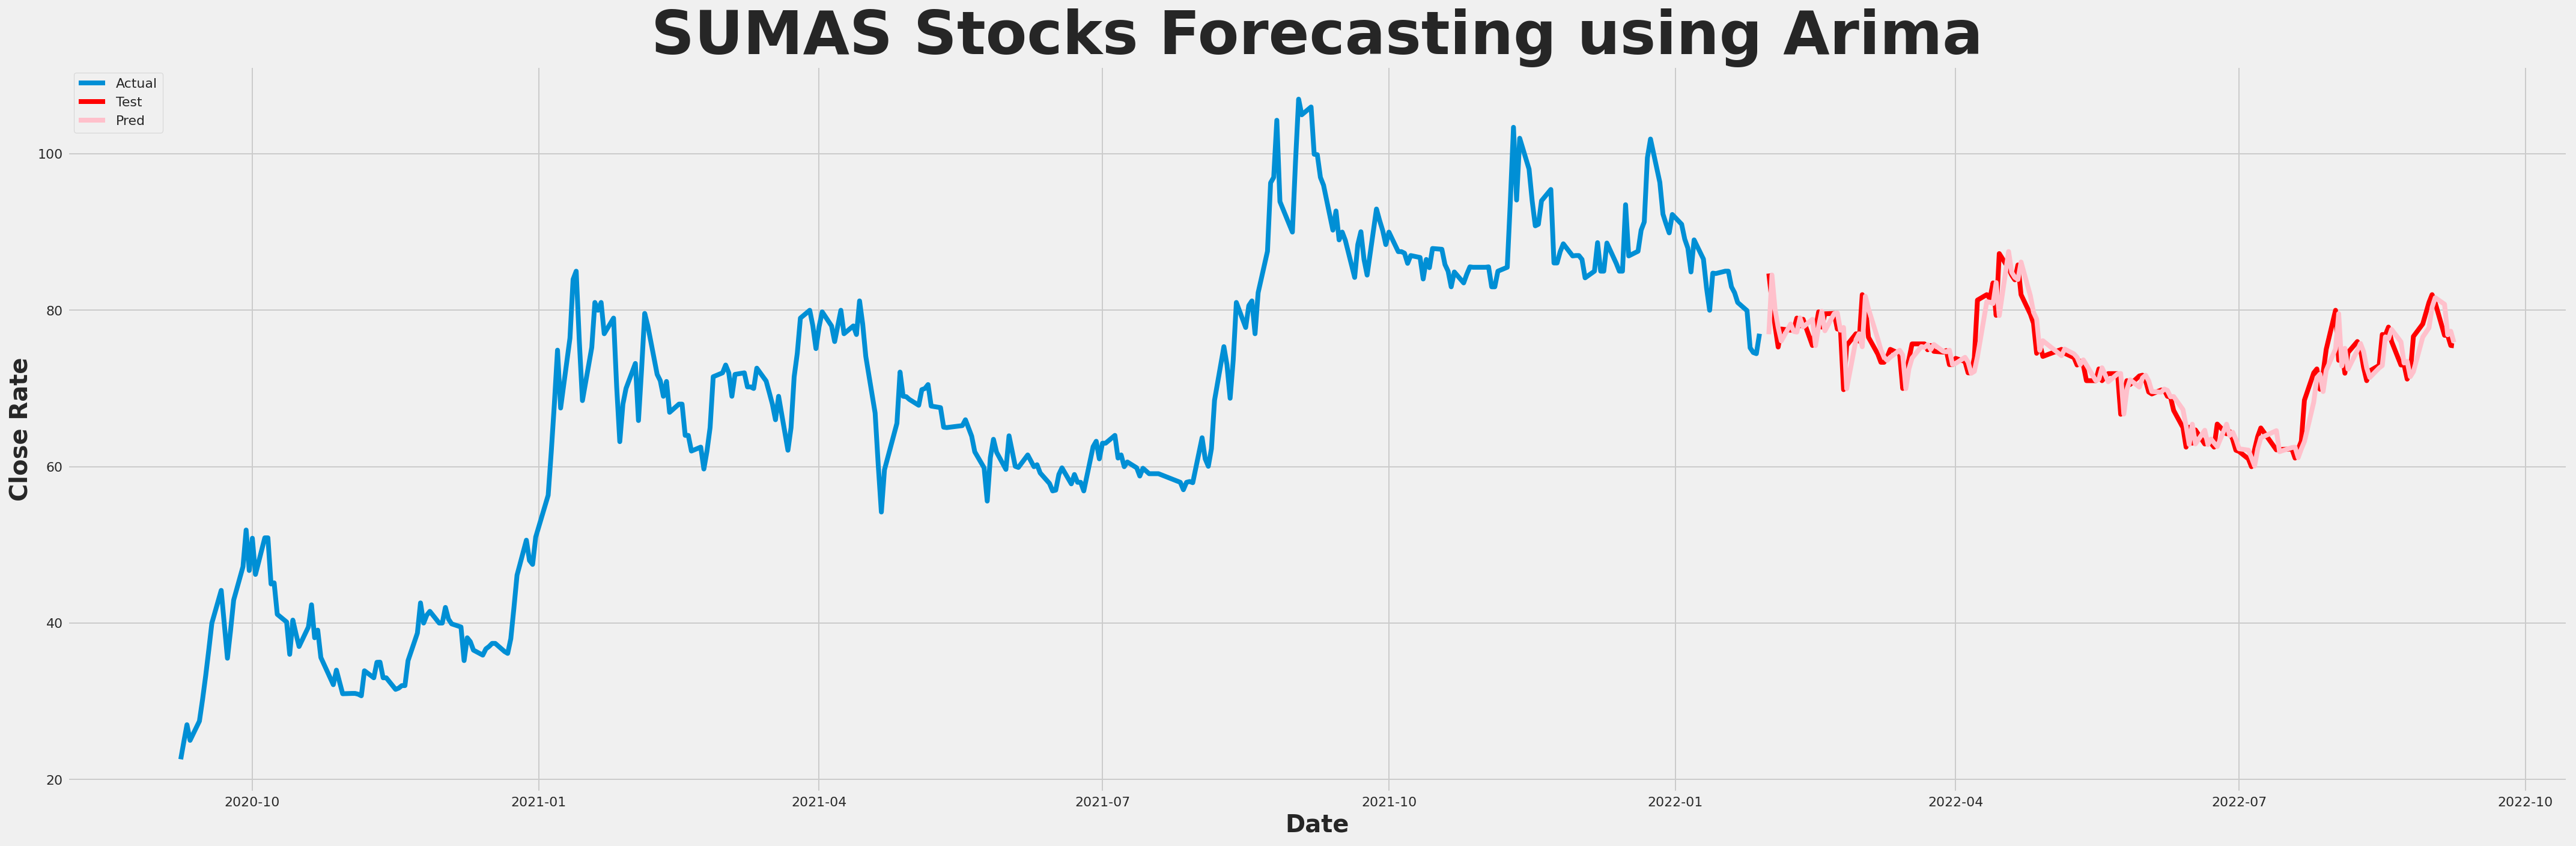

In [32]:
#df.Datetime = pd.to_datetime(df.Datetime)
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,10))
plt.title("SUMAS Stocks Forecasting using Arima",fontsize=50)
plt.plot(df[["Datetime","Close"]].iloc[:c].set_index("Datetime"))
plt.plot(test,color="red")
plt.plot(pred,color="pink")
plt.legend(["Actual","Test","Pred"], loc='upper left')
plt.xlabel("Date",fontsize=20)
plt.ylabel("Close Rate",fontsize=20)
plt.show()

In [33]:
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True, figsize=(12, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

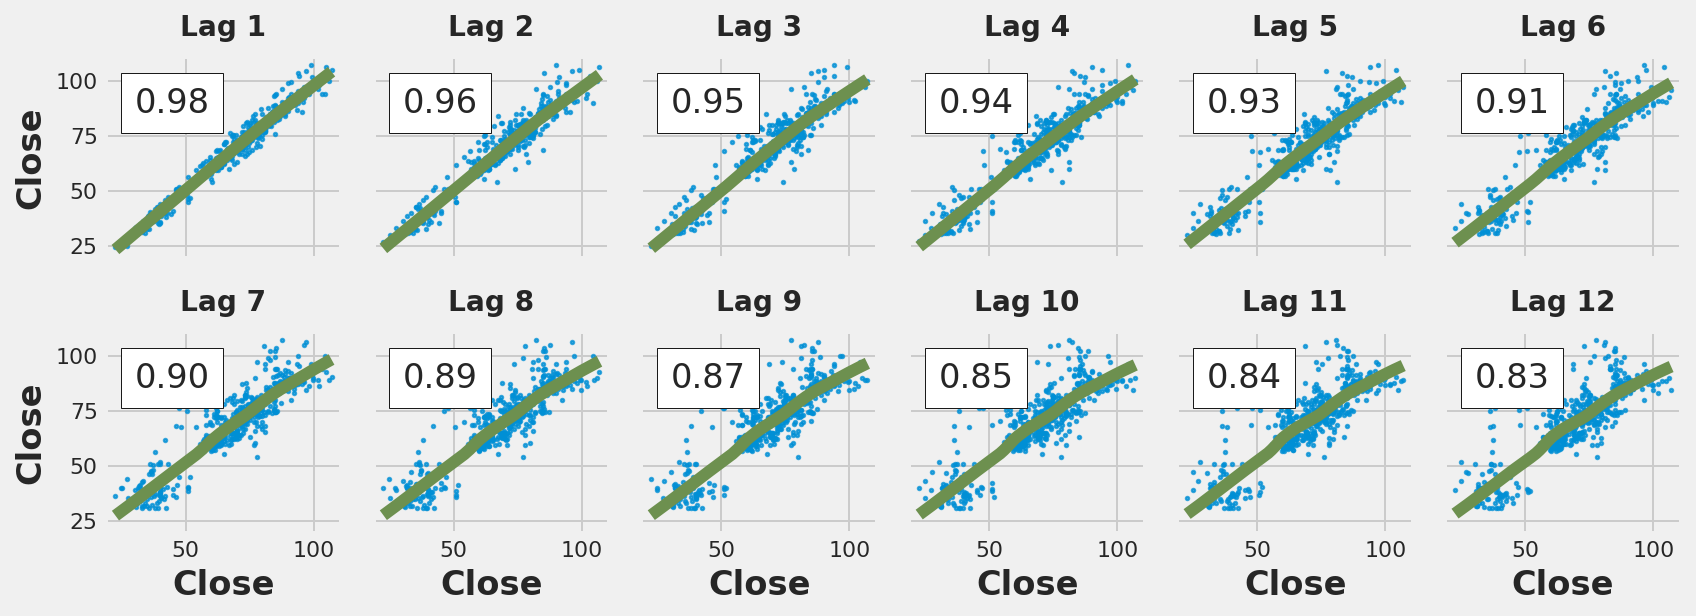

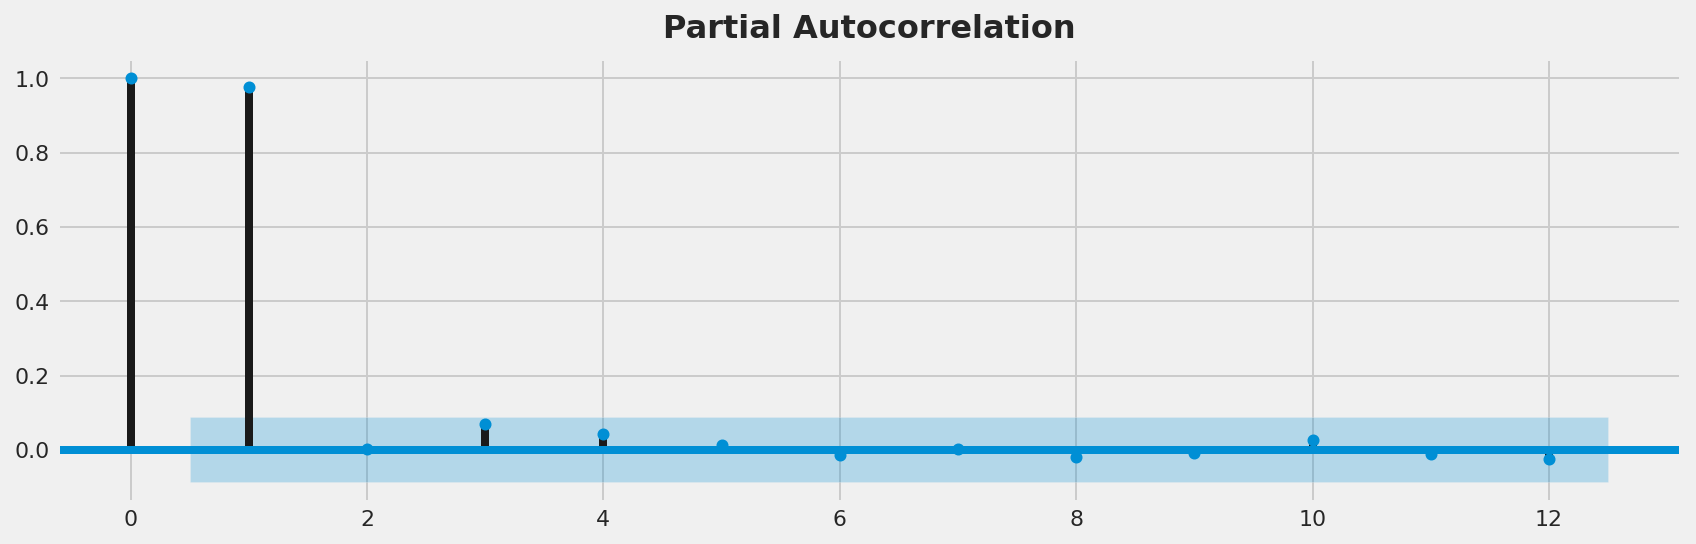

In [34]:
_ = plot_lags(df.Close, lags=12, nrows=2)
_ = plot_pacf(df.Close, lags=12)

In [35]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(df.Close, lags=2)
X = X.fillna(0.0)

In [36]:
y = df.set_index("Datetime").Close.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


model = LinearRegression()  
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

In [37]:
MSE_error_lr = mean_squared_error(y_test,y_fore)
print('Testing Mean Squared Error for LinearRegression is {}'.format(MSE_error_lr))

Testing Mean Squared Error for LinearRegression is 5.6944449947632485


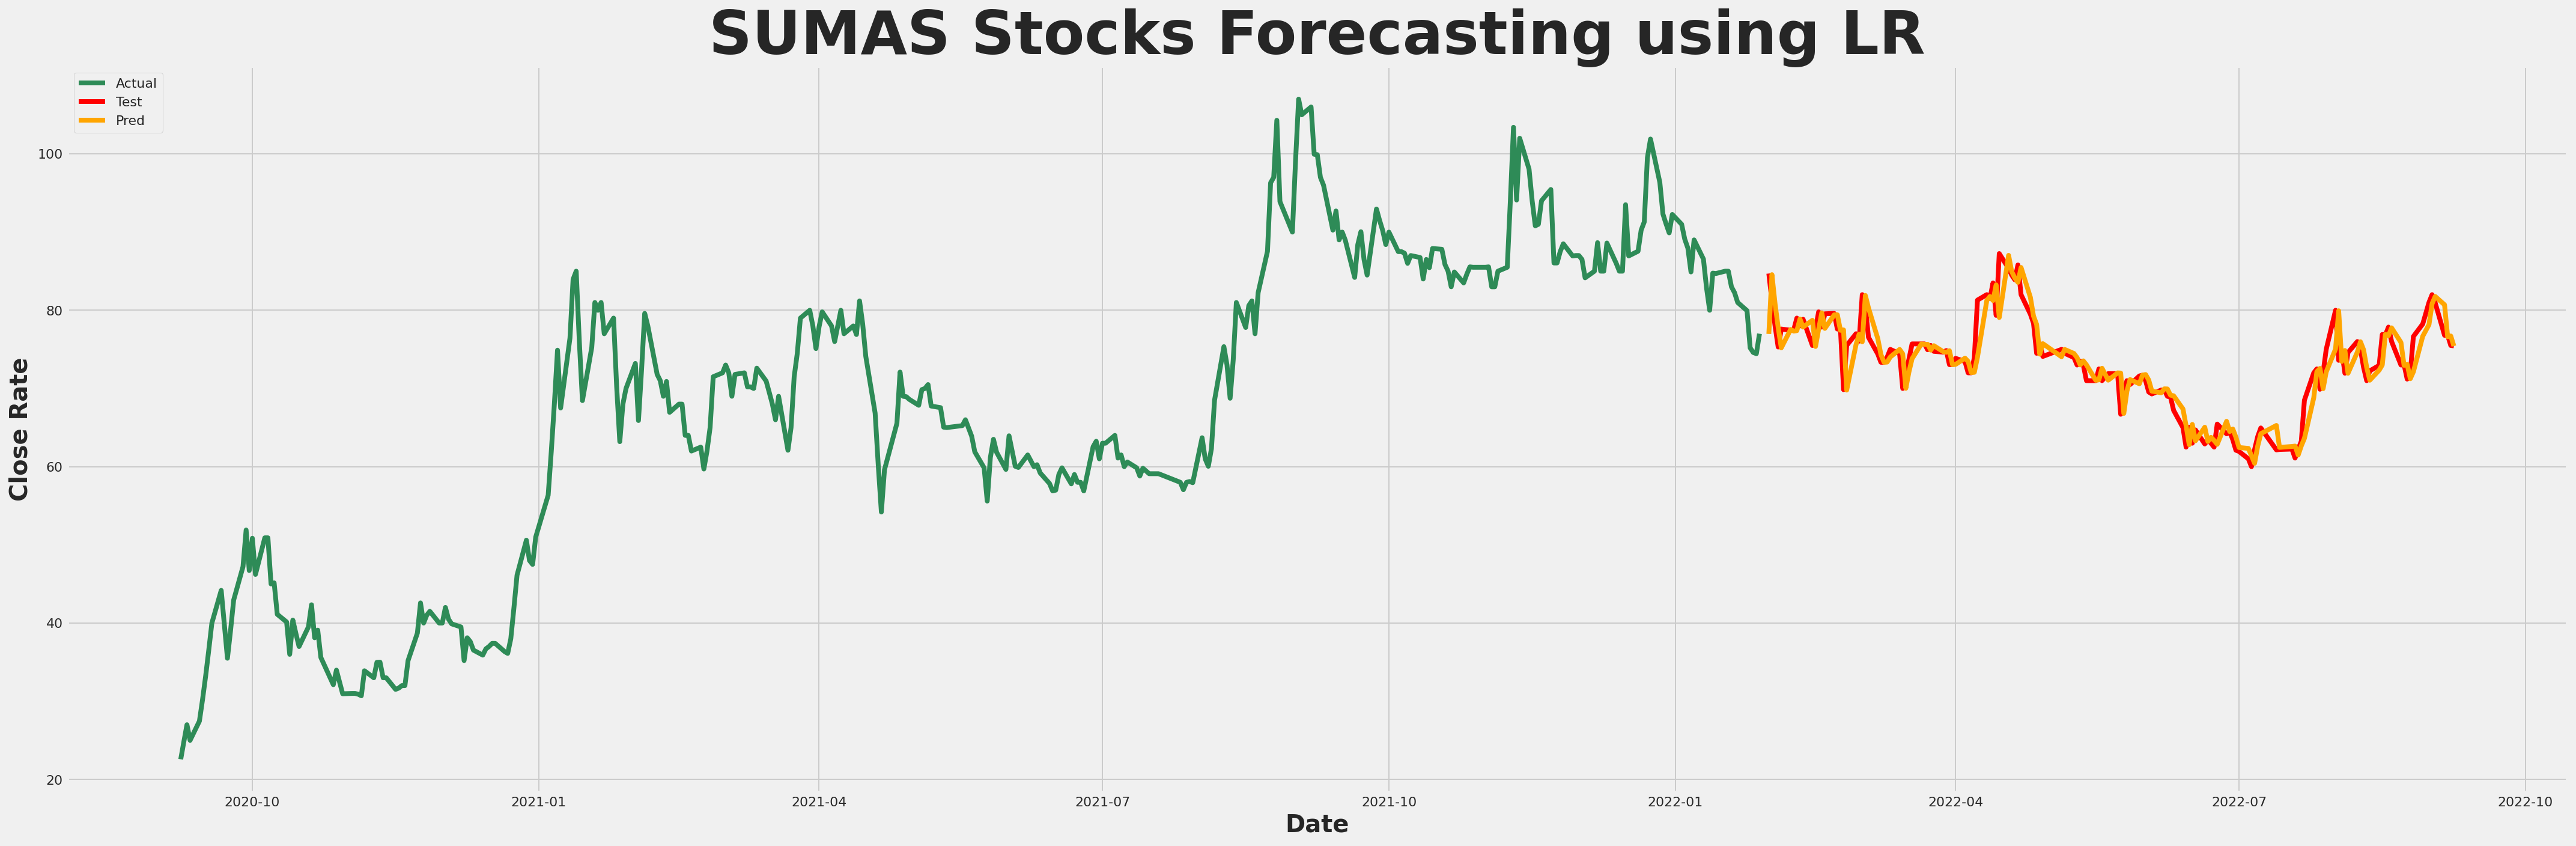

In [38]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,10))
plt.title("SUMAS Stocks Forecasting using LR",fontsize=50)
plt.plot(y_train,color="seagreen")
plt.plot(y_test,color="red")
plt.plot(y_fore,color="orange")
plt.legend(["Actual","Test","Pred"], loc='upper left')
plt.xlabel("Date",fontsize=20)
plt.ylabel("Close Rate",fontsize=20)
plt.show()

In [39]:
scaler= MinMaxScaler()
data  = df.filter(["Close"])
training_dataset = math.ceil(len(data)*.7)
data = data.values
scaled_data = scaler.fit_transform(data)
train_data,test_data = scaled_data[0:training_dataset],scaled_data[training_dataset:len(df)]
def train_test_split(data,time_step=1):
    xdata = []
    ydata = []
    for i in range(len(data)-time_step-1):
        xdata.append(data[i:(i+time_step),0])
        ydata.append(data[i+time_step,0])
    return np.array(xdata),np.array(ydata)

x_train,y_train =  train_test_split(train_data,2)
x_test,y_test = train_test_split(test_data,2)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [40]:
opt = Adam(learning_rate=0.0001)
def Model(l1_node = 50,l2_node=50,l3_node = 50,opt = "adam",lose = "mean_squared_error"):
    model = Sequential()
    model.add(LSTM(l1_node,return_sequences= True,input_shape = x_train.shape[1:]))
    model.add(LSTM(l2_node,return_sequences= True))
    model.add(LSTM(l3_node))
    model.add(Dense(1))
    model.compile(loss = lose,optimizer=opt)
    return model

In [41]:
model =Model(opt=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 2, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [42]:
history  = model.fit(x_train,y_train,epochs=250,batch_size=64,verbose=0)

In [43]:
eva = model.evaluate(x_test,y_test)
print(f"Model  loss on Scaled testing {eva}")

5/5 [==============================] - 1s 5ms/step - loss: 0.0015
Model  loss on Scaled testing 0.0014580599963665009


In [44]:
Actual_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0],1))
Actual_train = scaler.inverse_transform(y_train.reshape(y_train.shape[0],1))
pred= model.predict(x_test)
Pred  = scaler.inverse_transform(pred)
MSE_error_lstm = mean_squared_error(Actual_test,Pred)
print('Testing Mean Squared Error for Lstm is {}'.format(MSE_error_lstm))

Testing Mean Squared Error for Lstm is 10.39121029509414


In [45]:
Pred = pd.DataFrame(Pred, columns=['Close'])
Pred.head()

,Close
0,79.064095
1,75.770317
2,74.161987
3,75.985336
4,75.875587


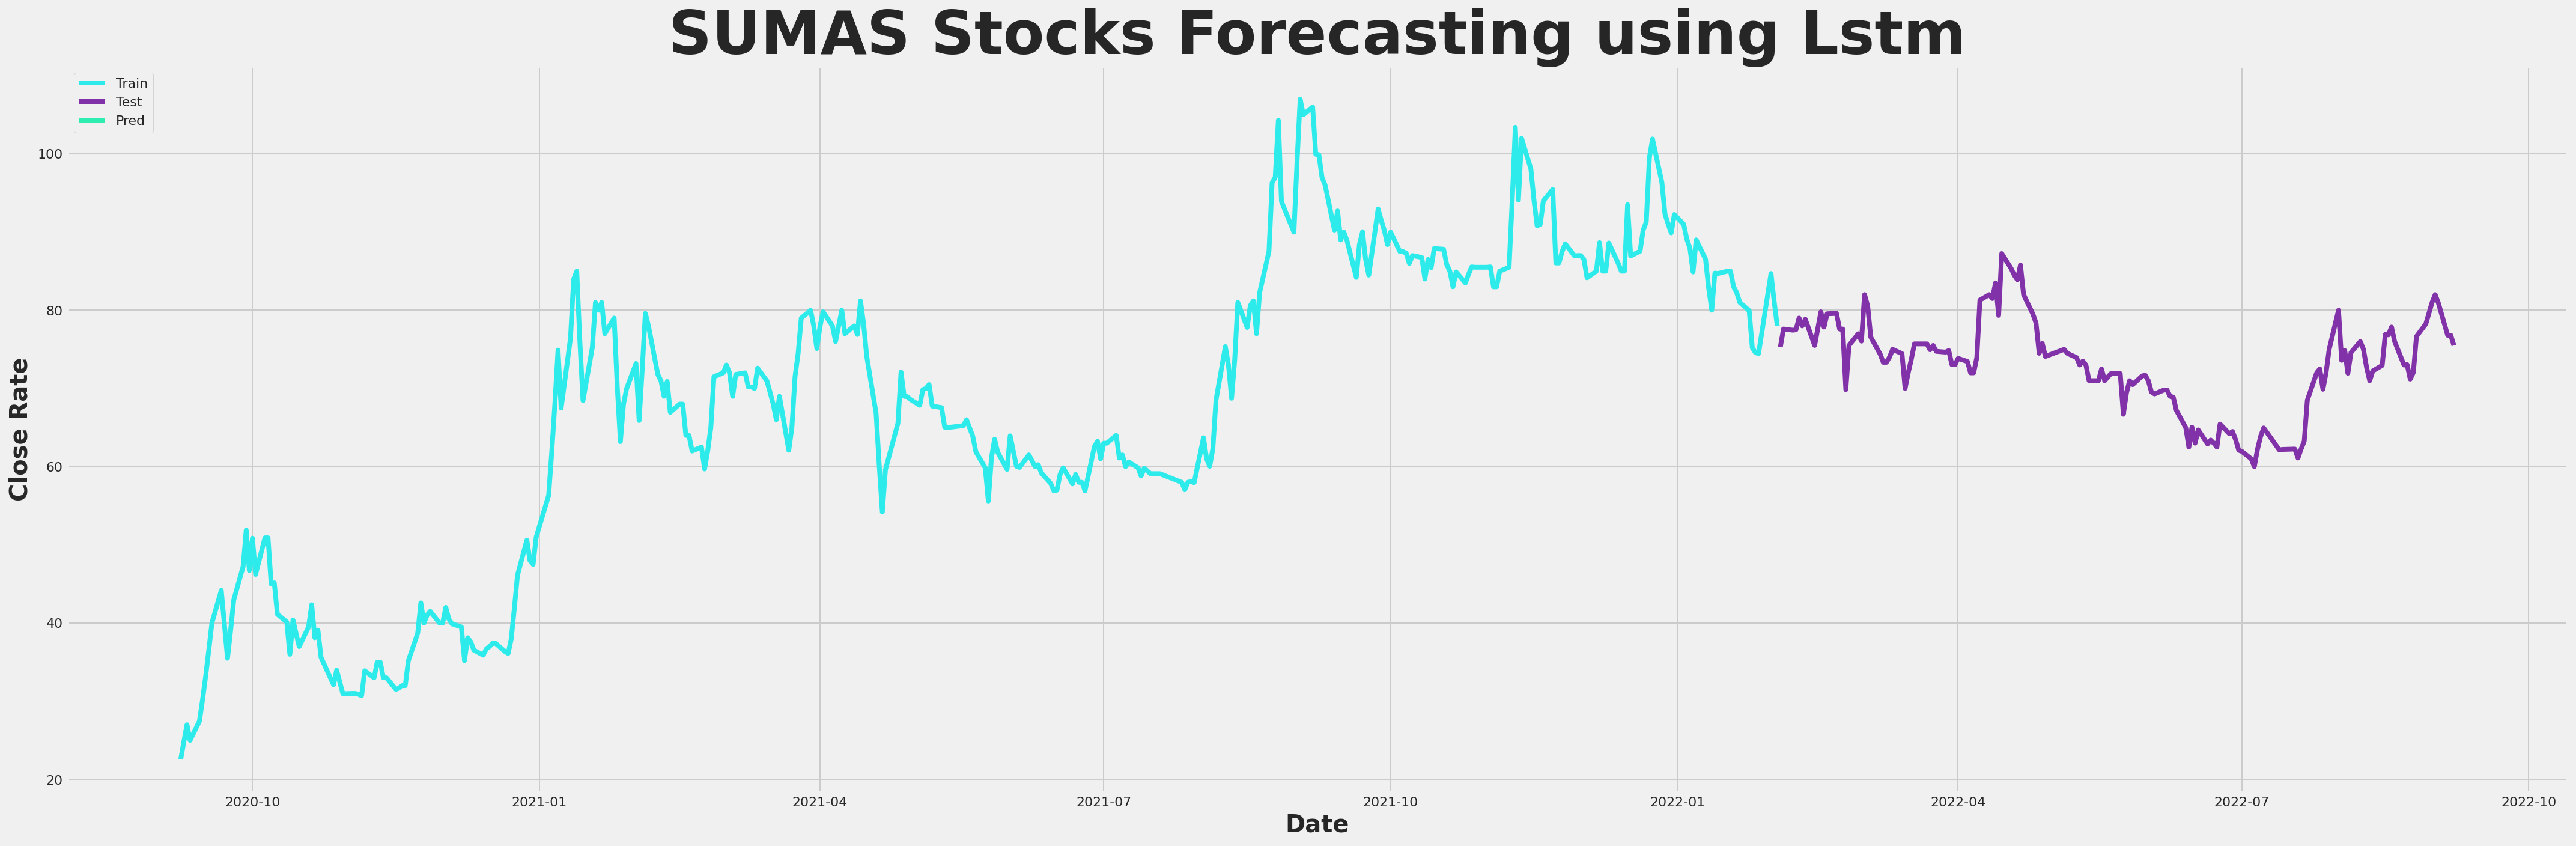

In [46]:
pred = pd.DataFrame()
pred["Date"]= df.loc[training_dataset+2:-1,"Datetime"]
pred["Close"] = Pred['Close']
pred = pred.set_index('Date')
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,10))
plt.title("SUMAS Stocks Forecasting using Lstm",fontsize=50)
plt.plot(df.set_index("Datetime")["Close"][:training_dataset+2],color="#2debeb")
plt.plot(df.set_index("Datetime")["Close"][training_dataset+2:-1],color="#8132a8")
plt.plot(pred,color="#2dedb0")
plt.legend(["Train","Test","Pred"], loc='upper left')
plt.xlabel("Date",fontsize=20)
plt.ylabel("Close Rate",fontsize=20)
plt.show()

In [47]:
print('Testing Mean Squared Error is for Arima {}'.format(MSE_error_arima))
print('Testing Mean Squared Error for LinearRegression is {}'.format(MSE_error_lr))
print('Testing Mean Squared Error for Lstm is {}'.format(MSE_error_lstm))

Testing Mean Squared Error is for Arima 5.838134547830341
Testing Mean Squared Error for LinearRegression is 5.6944449947632485
Testing Mean Squared Error for Lstm is 10.39121029509414
